In [1]:
# Cell 1: Import libraries dan setup environment
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random

print("Checking installed packages:")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


Checking installed packages:
TensorFlow version: 2.15.0
NumPy version: 1.24.3
Pandas version: 1.5.3


CSV loaded successfully!

Data distribution:
Topwear       15405
Shoes          7344
Bags           3055
Bottomwear     2694
Watches        2542
Dress           478
Headwear        293
Name: subCategory, dtype: int64


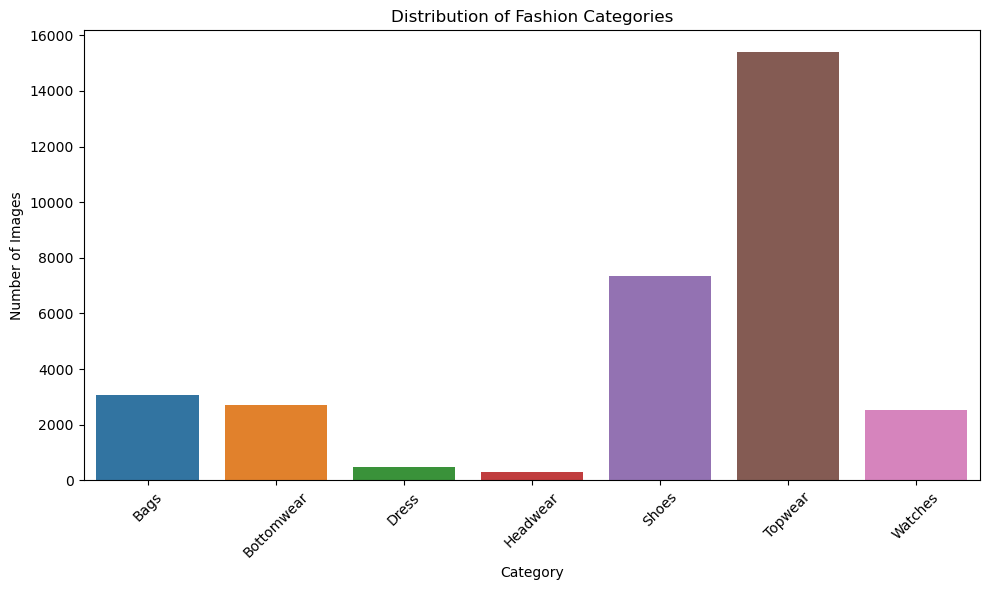

In [2]:
def analyze_dataset(csv_path='../Data/filtered_categories.csv'):
    try:
        df = pd.read_csv(csv_path)
        print("CSV loaded successfully!")
        
        print("\nData distribution:")
        print(df['subCategory'].value_counts())
        
        # Visualize distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x='subCategory')
        plt.xticks(rotation=45)
        plt.title('Distribution of Fashion Categories')
        plt.xlabel('Category')
        plt.ylabel('Number of Images')
        plt.tight_layout()
        plt.show()
        
        return df
        
    except Exception as e:
        print(f"Error loading CSV: {str(e)}")
        return None
# Load balanced data
df = analyze_dataset()


In [ ]:
# Cell 3: Data Loading Function dengan batasan yang lebih besar
def load_limited_data(df, data_dir='../Dataset', samples_per_class=1000):  # Mengubah dari 200 menjadi 1000
    images = []
    labels = []
    class_names = ['Bags', 'Bottomwear', 'Dress', 'Headwear', 'Shoes', 'Topwear', 'Watches']
    class_map = {name: idx for idx, name in enumerate(class_names)}
    
    print("\nLoading images...")
    total_processed = 0
    
    for category in class_names:
        print(f"\nProcessing {category}")
        category_path = os.path.join(data_dir, category)
        if not os.path.exists(category_path):
            print(f"Directory not found: {category_path}")
            continue
        
        # Get list of all files in category
        all_files = os.listdir(category_path)
        # Randomly select 1000 files or less if not enough files
        selected_files = random.sample(all_files, min(samples_per_class, len(all_files)))
        
        for file in selected_files:
            try:
                img_path = os.path.join(category_path, file)
                img = load_img(img_path, target_size=(177, 177))  # Mengurangi ukuran gambar
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(class_map[category])
                
                total_processed += 1
                if total_processed % 50 == 0:
                    print(f"Processed {total_processed} images")
                    
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
    
    print(f"\nTotal processed images: {total_processed}")
    return np.array(images), np.array(labels), class_names

# Load dataset dengan batasan yang lebih besar
X, y, class_names = load_limited_data(df)


Loading images...

Processing Bags
Processed 50 images
Processed 100 images
Processed 150 images
Processed 200 images
Processed 250 images
Processed 300 images
Processed 350 images
Processed 400 images
Processed 450 images
Processed 500 images
Processed 550 images
Processed 600 images
Processed 650 images
Processed 700 images
Processed 750 images
Processed 800 images
Processed 850 images
Processed 900 images
Processed 950 images
Processed 1000 images

Processing Bottomwear
Processed 1050 images
Processed 1100 images
Processed 1150 images
Processed 1200 images
Processed 1250 images
Processed 1300 images
Processed 1350 images
Processed 1400 images
Processed 1450 images
Processed 1500 images
Processed 1550 images
Processed 1600 images
Processed 1650 images
Processed 1700 images
Processed 1750 images
Processed 1800 images
Processed 1850 images
Processed 1900 images
Processed 1950 images
Processed 2000 images

Processing Dress
Processed 2050 images
Processed 2100 images
Processed 2150 imag

In [4]:
# Cell 4: Data Splitting and Preprocessing
# Split data dengan proporsi yang sama
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("\nData shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


Data shapes:
X_train: (4616, 150, 150, 3)
X_test: (1155, 150, 150, 3)


In [5]:
# Cell 5: Model Architecture
def create_improved_model(input_shape=(150, 150, 3), num_classes=7):
    model = models.Sequential([
        # Data Augmentation Layer
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Third Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [6]:
# Cell 6: Model Training
# Training configuration
train_config = {
    'batch_size': 16,
    'epochs': 50,
    'validation_split': 0.2,
    'callbacks': [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.001
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )
    ]
}

# Create model
model = create_improved_model(input_shape=(150, 150, 3))

# Build and compile model  
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training
history = model.fit(
    X_train,
    y_train, 
    validation_data=(X_test, y_test),
    batch_size=train_config['batch_size'],
    epochs=train_config['epochs'],
    callbacks=train_config['callbacks']
)



Epoch 1/50


289/289 [==============================] - 97s 311ms/step - loss: 4.7877 - accuracy: 0.5743 - val_loss: 4.9453 - val_accuracy: 0.5108 - lr: 1.0000e-04
Epoch 2/50
289/289 [==============================] - 75s 259ms/step - loss: 4.0227 - accuracy: 0.7509 - val_loss: 3.7709 - val_accuracy: 0.8199 - lr: 1.0000e-04
Epoch 3/50
289/289 [==============================] - 77s 268ms/step - loss: 3.5314 - accuracy: 0.8039 - val_loss: 3.2083 - val_accuracy: 0.8727 - lr: 1.0000e-04
Epoch 4/50
289/289 [==============================] - 75s 260ms/step - loss: 3.1330 - accuracy: 0.8213 - val_loss: 2.9018 - val_accuracy: 0.8892 - lr: 1.0000e-04
Epoch 5/50
289/289 [==============================] - 75s 258ms/step - loss: 2.7754 - accuracy: 0.8477 - val_loss: 2.7151 - val_accuracy: 0.8519 - lr: 1.0000e-04
Epoch 6/50
289/289 [==============================] - 71s 246ms/step - loss: 2.4651 - accuracy: 0.8553 - val_loss: 2.3049 - val_accuracy: 0.8970 - lr: 1.0000e-04
Epoch 7/50
289/289 [====

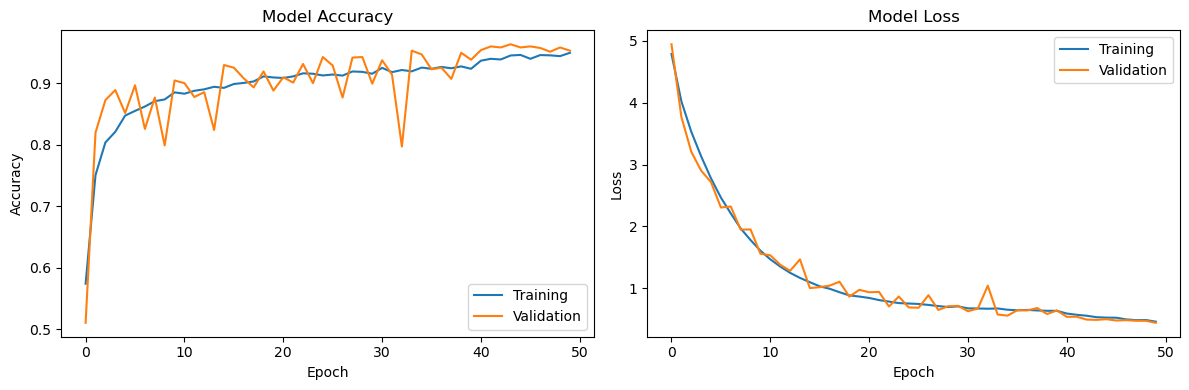

37/37 [==============================] - 4s 97ms/step

Classification Report:
              precision    recall  f1-score   support

        Bags       0.97      0.95      0.96       200
  Bottomwear       0.96      0.97      0.97       200
       Dress       0.78      0.93      0.85        96
    Headwear       0.93      0.95      0.94        59
       Shoes       0.99      1.00      0.99       200
     Topwear       0.95      0.92      0.93       200
     Watches       1.00      0.94      0.97       200

    accuracy                           0.95      1155
   macro avg       0.94      0.95      0.94      1155
weighted avg       0.96      0.95      0.95      1155



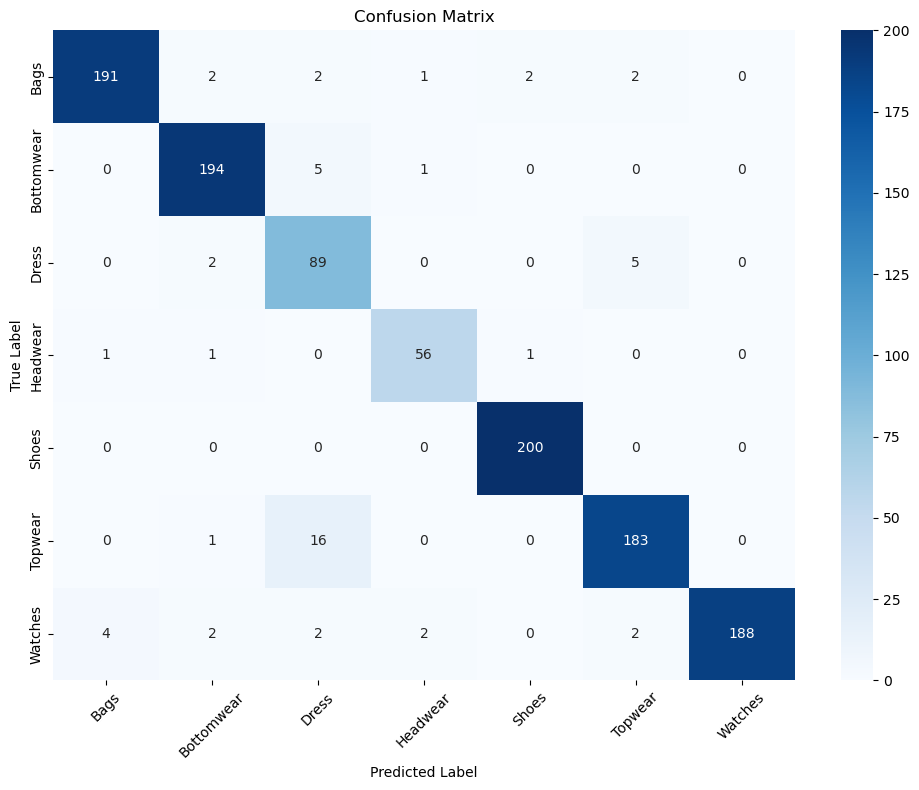

In [7]:
# Cell 7: Evaluation and Visualization
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Cell 8: Save Model and Class Names
# Simpan model
model.save('fashion_classifier_model')

# Simpan class names ke JSON
import json
class_names_dict = class_names.tolist() if hasattr(class_names, 'tolist') else class_names
with open('class_names.json', 'w') as f:
    json.dump(class_names_dict, f)

print("Model and class names saved successfully!")


INFO:tensorflow:Assets written to: fashion_classifier_model\assets


INFO:tensorflow:Assets written to: fashion_classifier_model\assets


Model and class names saved successfully!


In [9]:
# Cell 8: Save Model with versioning
import os
from datetime import datetime
import json

# Buat folder models jika belum ada
if not os.path.exists('models'):
    os.makedirs('models')

# Generate nama versi berdasarkan timestamp
version = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f'models/fashion_classifier_v{version}'

# Buat folder untuk versi ini
os.makedirs(model_path)

# Simpan model dalam format H5
model.save(os.path.join(model_path, 'model.h5'))

# Simpan model dalam format JSON
model_json = model.to_json()
with open(os.path.join(model_path, 'model.json'), 'w') as f:
    f.write(model_json)
    
# Simpan weights secara terpisah
model.save_weights(os.path.join(model_path, 'model_weights.h5'))

# Simpan class names ke JSON
class_names_dict = class_names.tolist() if hasattr(class_names, 'tolist') else class_names
with open(os.path.join(model_path, 'class_names.json'), 'w') as f:
    json.dump(class_names_dict, f)

print(f"Model and class names saved successfully in {model_path}!")

Model and class names saved successfully in models/fashion_classifier_v20241121_221129!


c:\Users\Legion\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
